In [4]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# reading the dataset
data = pd.read_csv("/content/email.csv")

In [8]:
#making a copy to save the original dataset
data_copy = data.copy()

In [9]:
data_copy.sample(5)

,Category,Message
5220,ham,I have to take exam with in march 3
2591,ham,Lol I have to take it. member how I said my au...
2194,ham,I called but no one pick up e phone. I ask bot...
3918,ham,Eh ur laptop got no stock lei... He say mon mu...
4812,ham,E admin building there? I might b slightly ear...


In [10]:
data_copy.shape

(5573, 2)

# Data Cleaning

In [11]:
#converting the classes into integers
data_copy.replace({"ham":1,"spam":0},inplace=True)

In [12]:
#checking if there any duplicated() data
data_copy.duplicated().sum()

415

In [13]:
#dropping duplicated data
data_copy.drop_duplicates(inplace=True)

In [14]:
#checking missing data
data_copy.isnull().sum()

Category    0
Message     0
dtype: int64

In [15]:
data_copy["Category"].value_counts()

Category
1                 4516
0                  641
{"mode":"full"       1
Name: count, dtype: int64

In [16]:
# dropping the unknown category in target column
data_copy = data_copy[data_copy["Category"] != '{"mode":"full"']

# Exploratory data analysis

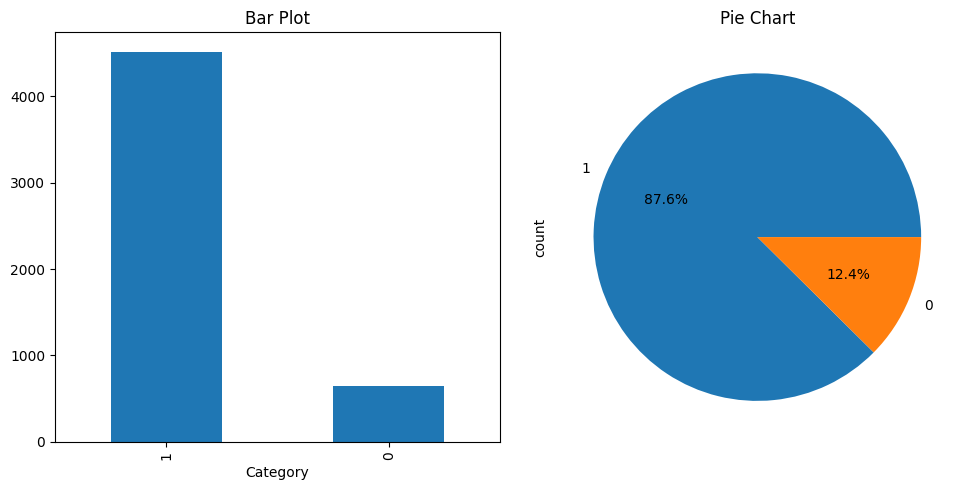

In [17]:
#checking the frequency count of target column via countplot and pie chart
plt.figure(figsize=(10, 5))

plt.subplot(121)
data_copy["Category"].value_counts().plot(kind="bar")
plt.title("Bar Plot")

plt.subplot(122)
data_copy["Category"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Pie Chart")

plt.tight_layout()
plt.show()



*   There is a unknown category we will drop it in data cleaning process beside that it seems that data is imbalance


#  Data Preprocessing

In [18]:
ps = PorterStemmer()

In [19]:
# Initialize the PorterStemmer
ps = PorterStemmer()

def transform_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Tokenization of the text
    text = nltk.word_tokenize(text)

    # Remove the special characters and keep only alphanumeric words
    List = [i for i in text if i.isalnum()]

    # Remove stop words and punctuation
    List = [word for word in List if word not in stopwords.words("english") and word not in string.punctuation]

    # Stemming our text
    List = [ps.stem(word) for word in List]

    # Return the processed text joined together
    return " ".join(List)


In [20]:
data_copy["Message"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [21]:
transform_text("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...")

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [22]:
#applying the fucntion on our text
data_copy["transformed_message"] = data_copy["Message"].apply(transform_text)

# Model Building

In [23]:
#now transforming our text via CountVector, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [24]:
#tfidfVectorizer
X = tfidf.fit_transform(data_copy["transformed_message"]).toarray()

In [25]:
#shape of new data
X.shape

(5157, 3000)

In [26]:
#storing the target variable in y
y = data_copy["Category"].values

In [27]:
#splitting the data into training and testing phase
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The accuracy of the GaussianNB is 0.8817829457364341,  precision is 0.9813432835820896, f1_score is 0.928235294117647 and recall is 0.8805803571428571
The accuracy of the MultinomialNB is 0.9777131782945736,  precision is 0.9749727965179543, f1_score is 0.98732782369146 and recall is 1.0
The accuracy of the BernoulliNB is 0.9854651162790697,  precision is 0.9856670341786108, f1_score is 0.9916805324459234 and recall is 0.9977678571428571


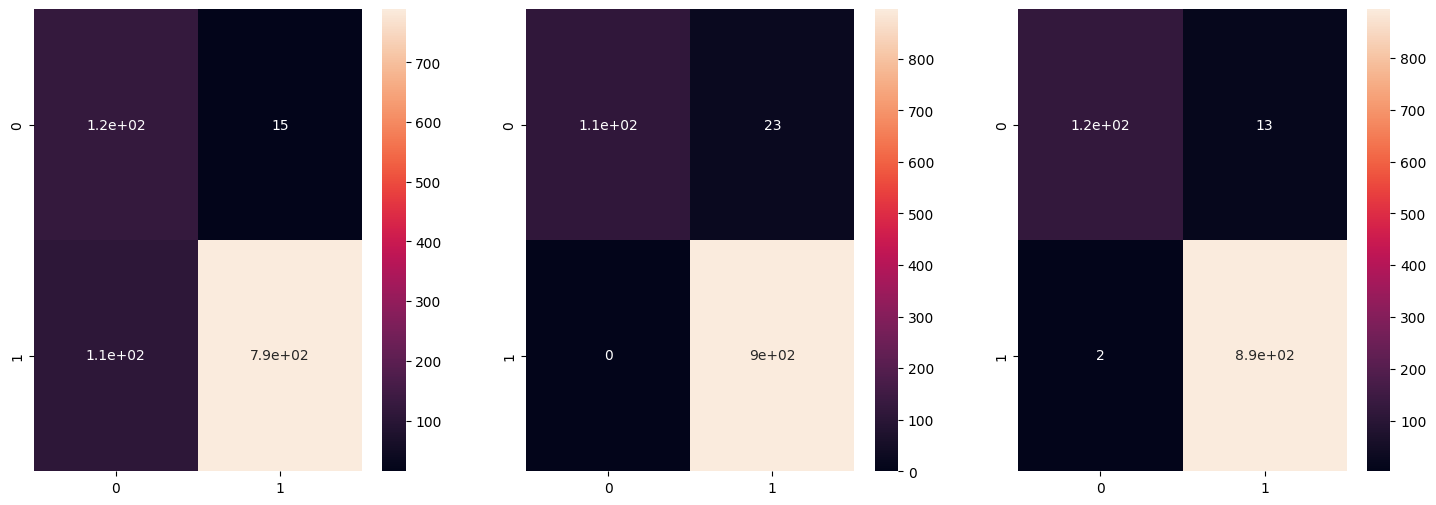

In [28]:
#making subplots for the models
fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(18,6))
ax.flatten()

# Models to test as per say that navie bayes works the best for the textual data so lets find out.
models = [GaussianNB(), MultinomialNB(), BernoulliNB()]

# Encode labels if they are not numeric (although they already are in this case)
if y_train.dtype == 'object' or y_test.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Ensure x_train and x_test are in the correct format for each model
for index,model in enumerate(models):
    if isinstance(model, MultinomialNB):
        # Ensure x_train and x_test contain non-negative counts
        x_train = np.abs(x_train)
        x_test = np.abs(x_test)
    elif isinstance(model, BernoulliNB):
        # Ensure x_train and x_test are binary
        x_train = (x_train > 0).astype(int)
        x_test = (x_test > 0).astype(int)

    # Fit and predict each model and print its accuracy and precision score
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1_Score = f1_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    print(f"The accuracy of the {model.__class__.__name__} is {accuracy},  precision is {precision}, f1_score is {f1_Score} and recall is {recall}")

    #now make a confusion matrix for each model
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,ax=ax[index])




*   It is clear that BernoulliNB has most accuracy and precision score and doing less FB mistakes.



In [29]:
#now lets try out same code but with more models so we can select one for further analysis
# Models to test
models = [GaussianNB(), MultinomialNB(), BernoulliNB(),SVC(kernel='sigmoid', gamma=1.0),
          KNeighborsClassifier(),DecisionTreeClassifier(max_depth=5),LogisticRegression(solver='liblinear', penalty='l1'),
          RandomForestClassifier(n_estimators=50, random_state=2),AdaBoostClassifier(n_estimators=50, random_state=2),
          BaggingClassifier(n_estimators=50, random_state=2),ExtraTreesClassifier(n_estimators=50, random_state=2),
          GradientBoostingClassifier(n_estimators=50,random_state=2),XGBClassifier(n_estimators=50,random_state=2)]

# Encode labels if they are not numeric (although they already are in this case)
if y_train.dtype == 'object' or y_test.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Ensure x_train and x_test are in the correct format for each model
for index,model in enumerate(models):
    if isinstance(model, MultinomialNB):
        # Ensure x_train and x_test contain non-negative counts
        x_train = np.abs(x_train)
        x_test = np.abs(x_test)
    elif isinstance(model, BernoulliNB):
        # Ensure x_train and x_test are binary
        x_train = (x_train > 0).astype(int)
        x_test = (x_test > 0).astype(int)

    # Fit and predict each model and print its accuracy and precision score
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"The accuracy of the {model.__class__.__name__} is {accuracy} and precision is {precision}")

The accuracy of the GaussianNB is 0.8817829457364341 and precision is 0.9825436408977556
The accuracy of the MultinomialNB is 0.9767441860465116 and precision is 0.9920993227990971
The accuracy of the BernoulliNB is 0.9854651162790697 and precision is 0.9856670341786108
The accuracy of the SVC is 0.9186046511627907 and precision is 0.9541387024608501
The accuracy of the KNeighborsClassifier is 0.9195736434108527 and precision is 0.9152196118488254
The accuracy of the DecisionTreeClassifier is 0.9292635658914729 and precision is 0.9290928050052137
The accuracy of the LogisticRegression is 0.9757751937984496 and precision is 0.9790979097909791
The accuracy of the RandomForestClassifier is 0.9777131782945736 and precision is 0.9780941949616648
The accuracy of the AdaBoostClassifier is 0.9573643410852714 and precision is 0.9691629955947136
The accuracy of the BaggingClassifier is 0.9670542635658915 and precision is 0.9821029082774049
The accuracy of the ExtraTreesClassifier is 0.9786821705



*   We are moving with the BernoulliNB



### Checking if we can increase the accuracy via dealing with imbalance data

In [30]:
# Oversampling to address class imbalance
ros = RandomOverSampler(random_state=42)
x_resampled_ros, y_resampled_ros = ros.fit_resample(x_train, y_train)

# Train the Gaussian Naive Bayes model on the oversampled data
gnb_ros = GaussianNB()
gnb_ros.fit(x_resampled_ros, y_resampled_ros)

# Make predictions on the test set using the oversampled model
y_preds_ros = gnb_ros.predict(x_test)

# Calculate accuracy and precision for the oversampled model
accuracy_ros = accuracy_score(y_test, y_preds_ros)
precision_ros = precision_score(y_test, y_preds_ros)

# Undersampling to address class imbalance
rus = RandomUnderSampler(random_state=42)
x_resampled_rus, y_resampled_rus = rus.fit_resample(x_train, y_train)

# Train the Gaussian Naive Bayes model on the undersampled data
gnb_rus = GaussianNB()
gnb_rus.fit(x_resampled_rus, y_resampled_rus)

# Make predictions on the test set using the undersampled model
y_preds_rus = gnb_rus.predict(x_test)

# Calculate accuracy and precision for the undersampled model
accuracy_rus = accuracy_score(y_test, y_preds_rus)
precision_rus = precision_score(y_test, y_preds_rus)

# Print the results
print("Results for Oversampling:")
print(f"Accuracy: {accuracy_ros}, Precision: {precision_ros}")

print("\nResults for Undersampling:")
print(f"Accuracy: {accuracy_rus}, Precision: {precision_rus}")

Results for Oversampling:
Accuracy: 0.8817829457364341, Precision: 0.9825436408977556

Results for Undersampling:
Accuracy: 0.939922480620155, Precision: 0.9882903981264637




*   No benefit

